# Installs:

In [1]:
from torcheeg.datasets import DREAMERDataset
from torcheeg import transforms
import matplotlib.pyplot as plt
import torch

2023-11-30 12:42:34,667 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 12:42:34,673 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 12:42:34,674 DEBUG MainThread matplotlib interactive is False
2023-11-30 12:42:34,675 DEBUG MainThread matplotlib platform is darwin
2023-11-30 12:42:34,716 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 12:42:34,718 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json


Steps for downloading found: https://torcheeg.readthedocs.io/en/stable/auto_examples/examples_dreamer_tsception.html

Needed to request data from: Download URL: https://zenodo.org/record/546113

k-fold tutorial: https://machinelearningmastery.com/k-fold-cross-validation/#:~:text=The%20results%20of%20a%20k,standard%20deviation%20or%20standard%20error.

k-fold Illustration: https://www.analyticsvidhya.com/blog/2022/02/k-fold-cross-validation-technique-and-its-essentials/

Request Accepted: Files uploaded to google drive folder

# Import the dataset:

In [2]:
dataset_path = "./DREAMER.mat"

In [3]:
dataset = DREAMERDataset(io_path='./examples_dreamer_tsception/dreamer',
                          mat_path=dataset_path,
                          offline_transform=transforms.Compose([transforms.BaselineRemoval(), transforms.MeanStdNormalize(), transforms.To2d()]),
                          online_transform=transforms.ToTensor(),
                          label_transform=transforms.Compose([transforms.Select('valence'),transforms.Binary(3.0)]),
                          chunk_size=128,
                          baseline_chunk_size=128,
                          num_baseline=61,
                          num_worker=4)

dataset already exists at path ./examples_dreamer_tsception/dreamer, reading from path...


In [4]:
# print a sample point
# for i in range(4000,4200):  #85050
sample_data, sample_label = dataset[0]
print(sample_data.shape)

# convert sample point to numpy to check dimension
# sample_data = sample_data.numpy()
# print('Sample data shape:', sample_data.shape)

torch.Size([1, 14, 128])


2023-11-30 12:42:35,645 DEBUG MainThread matplotlib.pyplot Loaded backend module://matplotlib_inline.backend_inline version unknown.
2023-11-30 12:42:35,647 DEBUG MainThread matplotlib.pyplot Loaded backend module://matplotlib_inline.backend_inline version unknown.
2023-11-30 12:42:35,649 DEBUG MainThread matplotlib.font_manager findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2023-11-30 12:42:35,650 DEBUG MainThread matplotlib.font_manager findfont: score(FontEntry(fname='/Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-BoldOblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 1.335
2023-11-30 12:42:35,651 DEBUG MainThread matplotlib.font_manager findfont: score(FontEntry(fname='/Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf', name='cmsy10', style='normal', 

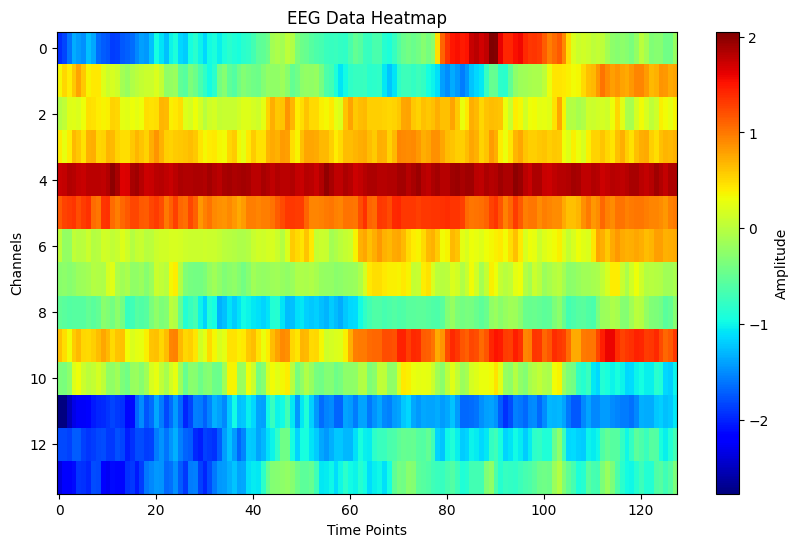

In [5]:
data = sample_data.squeeze(0)

plt.figure(figsize=(10, 6))
plt.imshow(data, aspect='auto', interpolation='nearest', cmap='jet')
plt.colorbar(label='Amplitude')
plt.xlabel('Time Points')
plt.ylabel('Channels')
plt.title('EEG Data Heatmap')
plt.show()

# Define the dataset splits:

In [12]:
from torcheeg.model_selection import KFoldGroupbyTrial
from torch.utils.data import random_split

# Assuming dataset is an instance of DREAMERDataset
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)  # 80% for training, 20% for testing
test_size = dataset_size - train_size

# Use random_split to split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Now train_dataset and test_dataset can be used for training and testing, respectively


In [7]:
NUM_SPLITS = 10

k_fold = KFoldGroupbyTrial(n_splits=NUM_SPLITS, split_path=f'./examples_dreamer_tsception/split')

# TRAINING:

In [13]:
from torch.utils.data import DataLoader
from torcheeg.models import TSCeption

from torcheeg.trainers import ClassifierTrainer
import pytorch_lightning as pl

for i, (train_dataset, val_dataset) in enumerate(k_fold.split(train_dataset)):
  train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=7)
  val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=7)

  model = TSCeption(num_electrodes=14,
                    num_classes=2,
                    num_T=15,
                    num_S=15,
                    in_channels=1,
                    hid_channels=32,
                    sampling_rate=128,
                    dropout=0.5)

  trainer = ClassifierTrainer(model=model,
                              num_classes=2,
                              lr=1e-4,
                              weight_decay=1e-4,
                              accelerator="gpu")
  trainer.fit(train_loader,
              val_loader,
              max_epochs=50,
              default_root_dir=f'./examples_dreamer_tsception/model/{i}',
              callbacks=[pl.callbacks.ModelCheckpoint(save_last=True)],
              enable_progress_bar=True,
              enable_model_summary=True,
              limit_val_batches=0.0)
  score = trainer.test(val_loader,
                        enable_progress_bar=True,
                        enable_model_summary=True)[0]
  print(f'Fold {i} test accuracy: {score["test_accuracy"]:.4f}')

2023-11-30 14:17:24,179 INFO MainThread pytorch_lightning.utilities.rank_zero GPU available: True (mps), used: True
2023-11-30 14:17:24,179 INFO MainThread pytorch_lightning.utilities.rank_zero TPU available: False, using: 0 TPU cores
2023-11-30 14:17:24,180 INFO MainThread pytorch_lightning.utilities.rank_zero IPU available: False, using: 0 IPUs
2023-11-30 14:17:24,180 INFO MainThread pytorch_lightning.utilities.rank_zero HPU available: False, using: 0 HPUs
2023-11-30 14:17:24,203 INFO MainThread pytorch_lightning.callbacks.model_summary 
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | TSCeption        | 7.8 K 
1 | ce_fn         | CrossEntropyLoss | 0     
2 | train_loss    | MeanMetric       | 0     
3 | val_loss      | MeanMetric       | 0     
4 | test_loss     | MeanMetric       | 0     
5 | train_metrics | MetricCollection | 0     
6 | val_metrics   | MetricCollection | 0     
7 | test_metrics  | MetricCollecti

Training: |          | 0/? [00:00<?, ?it/s]

2023-11-30 14:19:22,856 DEBUG MainThread fsspec.local open file: /Users/arnoldcheskis/Documents/Deep learning/Project/rerun- tsception/examples_dreamer_tsception/model/0/lightning_logs/version_1/checkpoints/epoch=0-step=1072.ckpt
2023-11-30 14:19:22,873 DEBUG MainThread fsspec.local open file: /Users/arnoldcheskis/Documents/Deep learning/Project/rerun- tsception/examples_dreamer_tsception/model/0/lightning_logs/version_1/checkpoints/last.ckpt



[Train] train_loss: 0.656 train_accuracy: 0.615 



2023-11-30 14:19:25,548 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 14:19:25,553 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 14:19:25,554 DEBUG MainThread matplotlib interactive is False
2023-11-30 14:19:25,554 DEBUG MainThread matplotlib platform is darwin
2023-11-30 14:19:25,598 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 14:19:25,600 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 14:19:28,907 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 14:19:28,911 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 14:19:28,912 DEBUG MainThread matplotlib interactive is False
2023-11-30 14:19:28,912 DEBUG Ma


[Train] train_loss: 0.619 train_accuracy: 0.654 



2023-11-30 14:21:44,723 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 14:21:44,729 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 14:21:44,730 DEBUG MainThread matplotlib interactive is False
2023-11-30 14:21:44,730 DEBUG MainThread matplotlib platform is darwin
2023-11-30 14:21:44,781 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 14:21:44,783 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 14:21:48,895 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 14:21:48,904 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 14:21:48,906 DEBUG MainThread matplotlib interactive is False
2023-11-30 14:21:48,906 DEBUG Ma


[Train] train_loss: 0.590 train_accuracy: 0.681 



2023-11-30 14:23:59,194 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 14:23:59,199 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 14:23:59,200 DEBUG MainThread matplotlib interactive is False
2023-11-30 14:23:59,200 DEBUG MainThread matplotlib platform is darwin
2023-11-30 14:23:59,245 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 14:23:59,247 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 14:24:02,049 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 14:24:02,054 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 14:24:02,055 DEBUG MainThread matplotlib interactive is False
2023-11-30 14:24:02,055 DEBUG Ma


[Train] train_loss: 0.568 train_accuracy: 0.700 



2023-11-30 14:38:06,897 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 14:38:06,902 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 14:38:06,903 DEBUG MainThread matplotlib interactive is False
2023-11-30 14:38:06,903 DEBUG MainThread matplotlib platform is darwin
2023-11-30 14:38:06,946 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 14:38:06,948 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 14:38:10,005 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 14:38:10,010 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 14:38:10,011 DEBUG MainThread matplotlib interactive is False
2023-11-30 14:38:10,011 DEBUG Ma


[Train] train_loss: 0.551 train_accuracy: 0.712 



2023-11-30 14:39:58,959 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 14:39:58,964 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 14:39:58,965 DEBUG MainThread matplotlib interactive is False
2023-11-30 14:39:58,965 DEBUG MainThread matplotlib platform is darwin
2023-11-30 14:39:59,008 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 14:39:59,010 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 14:40:01,896 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 14:40:01,901 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 14:40:01,902 DEBUG MainThread matplotlib interactive is False
2023-11-30 14:40:01,902 DEBUG Ma


[Train] train_loss: 0.536 train_accuracy: 0.724 



2023-11-30 14:42:00,667 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 14:42:00,674 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 14:42:00,676 DEBUG MainThread matplotlib interactive is False
2023-11-30 14:42:00,676 DEBUG MainThread matplotlib platform is darwin
2023-11-30 14:42:00,726 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 14:42:00,728 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 14:42:04,372 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 14:42:04,387 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 14:42:04,390 DEBUG MainThread matplotlib interactive is False
2023-11-30 14:42:04,390 DEBUG Ma


[Train] train_loss: 0.524 train_accuracy: 0.733 



2023-11-30 14:44:17,598 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 14:44:17,603 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 14:44:17,604 DEBUG MainThread matplotlib interactive is False
2023-11-30 14:44:17,604 DEBUG MainThread matplotlib platform is darwin
2023-11-30 14:44:17,647 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 14:44:17,649 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 14:44:20,468 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 14:44:20,473 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 14:44:20,474 DEBUG MainThread matplotlib interactive is False
2023-11-30 14:44:20,474 DEBUG Ma


[Train] train_loss: 0.515 train_accuracy: 0.738 



2023-11-30 14:46:11,644 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 14:46:11,649 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 14:46:11,650 DEBUG MainThread matplotlib interactive is False
2023-11-30 14:46:11,650 DEBUG MainThread matplotlib platform is darwin
2023-11-30 14:46:11,693 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 14:46:11,695 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 14:46:14,476 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 14:46:14,480 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 14:46:14,481 DEBUG MainThread matplotlib interactive is False
2023-11-30 14:46:14,481 DEBUG Ma


[Train] train_loss: 0.504 train_accuracy: 0.746 



2023-11-30 14:48:10,294 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 14:48:10,299 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 14:48:10,300 DEBUG MainThread matplotlib interactive is False
2023-11-30 14:48:10,300 DEBUG MainThread matplotlib platform is darwin
2023-11-30 14:48:10,343 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 14:48:10,345 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 14:48:13,207 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 14:48:13,212 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 14:48:13,213 DEBUG MainThread matplotlib interactive is False
2023-11-30 14:48:13,213 DEBUG Ma


[Train] train_loss: 0.498 train_accuracy: 0.750 



2023-11-30 14:50:08,682 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 14:50:08,686 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 14:50:08,688 DEBUG MainThread matplotlib interactive is False
2023-11-30 14:50:08,688 DEBUG MainThread matplotlib platform is darwin
2023-11-30 14:50:08,731 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 14:50:08,733 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 14:50:11,506 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 14:50:11,511 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 14:50:11,512 DEBUG MainThread matplotlib interactive is False
2023-11-30 14:50:11,512 DEBUG Ma


[Train] train_loss: 0.490 train_accuracy: 0.754 



2023-11-30 14:52:14,184 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 14:52:14,189 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 14:52:14,190 DEBUG MainThread matplotlib interactive is False
2023-11-30 14:52:14,190 DEBUG MainThread matplotlib platform is darwin
2023-11-30 14:52:14,234 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 14:52:14,235 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 14:52:17,034 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 14:52:17,039 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 14:52:17,040 DEBUG MainThread matplotlib interactive is False
2023-11-30 14:52:17,040 DEBUG Ma


[Train] train_loss: 0.485 train_accuracy: 0.758 



2023-11-30 14:54:19,911 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 14:54:19,916 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 14:54:19,917 DEBUG MainThread matplotlib interactive is False
2023-11-30 14:54:19,917 DEBUG MainThread matplotlib platform is darwin
2023-11-30 14:54:19,961 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 14:54:19,963 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 14:54:22,757 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 14:54:22,762 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 14:54:22,763 DEBUG MainThread matplotlib interactive is False
2023-11-30 14:54:22,763 DEBUG Ma


[Train] train_loss: 0.479 train_accuracy: 0.762 



2023-11-30 14:56:27,713 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 14:56:27,718 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 14:56:27,719 DEBUG MainThread matplotlib interactive is False
2023-11-30 14:56:27,719 DEBUG MainThread matplotlib platform is darwin
2023-11-30 14:56:27,763 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 14:56:27,765 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 14:56:30,679 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 14:56:30,683 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 14:56:30,684 DEBUG MainThread matplotlib interactive is False
2023-11-30 14:56:30,684 DEBUG Ma


[Train] train_loss: 0.475 train_accuracy: 0.765 



2023-11-30 14:58:19,474 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 14:58:19,478 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 14:58:19,479 DEBUG MainThread matplotlib interactive is False
2023-11-30 14:58:19,479 DEBUG MainThread matplotlib platform is darwin
2023-11-30 14:58:19,523 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 14:58:19,525 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 14:58:22,416 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 14:58:22,421 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 14:58:22,422 DEBUG MainThread matplotlib interactive is False
2023-11-30 14:58:22,422 DEBUG Ma


[Train] train_loss: 0.472 train_accuracy: 0.767 



2023-11-30 15:00:35,380 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:00:35,385 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:00:35,386 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:00:35,386 DEBUG MainThread matplotlib platform is darwin
2023-11-30 15:00:35,429 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:00:35,431 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 15:00:38,370 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:00:38,374 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:00:38,376 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:00:38,376 DEBUG Ma


[Train] train_loss: 0.468 train_accuracy: 0.772 



2023-11-30 15:02:37,779 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:02:37,784 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:02:37,785 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:02:37,785 DEBUG MainThread matplotlib platform is darwin
2023-11-30 15:02:37,829 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:02:37,831 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 15:02:40,640 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:02:40,644 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:02:40,645 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:02:40,645 DEBUG Ma


[Train] train_loss: 0.463 train_accuracy: 0.772 



2023-11-30 15:04:29,641 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:04:29,646 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:04:29,647 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:04:29,647 DEBUG MainThread matplotlib platform is darwin
2023-11-30 15:04:29,691 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:04:29,693 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 15:04:32,715 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:04:32,720 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:04:32,722 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:04:32,722 DEBUG Ma


[Train] train_loss: 0.460 train_accuracy: 0.774 



2023-11-30 15:06:33,515 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:06:33,520 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:06:33,521 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:06:33,521 DEBUG MainThread matplotlib platform is darwin
2023-11-30 15:06:33,564 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:06:33,566 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 15:06:36,374 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:06:36,379 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:06:36,380 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:06:36,380 DEBUG Ma


[Train] train_loss: 0.458 train_accuracy: 0.777 



2023-11-30 15:08:27,722 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:08:27,727 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:08:27,728 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:08:27,728 DEBUG MainThread matplotlib platform is darwin
2023-11-30 15:08:27,771 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:08:27,773 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 15:08:30,568 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:08:30,573 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:08:30,574 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:08:30,574 DEBUG Ma


[Train] train_loss: 0.454 train_accuracy: 0.778 



2023-11-30 15:10:41,322 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:10:41,328 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:10:41,329 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:10:41,329 DEBUG MainThread matplotlib platform is darwin
2023-11-30 15:10:41,384 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:10:41,386 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 15:10:46,079 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:10:46,085 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:10:46,086 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:10:46,087 DEBUG Ma


[Train] train_loss: 0.450 train_accuracy: 0.782 



2023-11-30 15:13:12,415 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:13:12,420 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:13:12,421 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:13:12,421 DEBUG MainThread matplotlib platform is darwin
2023-11-30 15:13:12,468 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:13:12,470 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 15:13:16,420 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:13:16,427 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:13:16,430 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:13:16,430 DEBUG Ma


[Train] train_loss: 0.448 train_accuracy: 0.783 



2023-11-30 15:15:36,277 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:15:36,282 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:15:36,283 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:15:36,283 DEBUG MainThread matplotlib platform is darwin
2023-11-30 15:15:36,326 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:15:36,328 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 15:15:39,165 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:15:39,170 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:15:39,171 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:15:39,171 DEBUG Ma


[Train] train_loss: 0.444 train_accuracy: 0.784 



2023-11-30 15:17:45,847 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:17:45,852 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:17:45,853 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:17:45,853 DEBUG MainThread matplotlib platform is darwin
2023-11-30 15:17:45,896 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:17:45,898 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 15:17:48,745 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:17:48,750 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:17:48,751 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:17:48,751 DEBUG Ma


[Train] train_loss: 0.441 train_accuracy: 0.785 



2023-11-30 15:20:06,314 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:20:06,319 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:20:06,320 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:20:06,320 DEBUG MainThread matplotlib platform is darwin
2023-11-30 15:20:06,364 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:20:06,366 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 15:20:10,680 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:20:10,685 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:20:10,687 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:20:10,687 DEBUG Ma


[Train] train_loss: 0.440 train_accuracy: 0.786 



2023-11-30 15:22:18,653 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:22:18,658 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:22:18,659 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:22:18,659 DEBUG MainThread matplotlib platform is darwin
2023-11-30 15:22:18,702 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:22:18,704 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 15:22:21,564 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:22:21,569 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:22:21,570 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:22:21,570 DEBUG Ma


[Train] train_loss: 0.437 train_accuracy: 0.788 



2023-11-30 15:24:39,667 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:24:39,672 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:24:39,673 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:24:39,673 DEBUG MainThread matplotlib platform is darwin
2023-11-30 15:24:39,716 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:24:39,718 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 15:24:42,493 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:24:42,497 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:24:42,498 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:24:42,498 DEBUG Ma


[Train] train_loss: 0.434 train_accuracy: 0.790 



2023-11-30 15:26:45,221 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:26:45,226 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:26:45,227 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:26:45,227 DEBUG MainThread matplotlib platform is darwin
2023-11-30 15:26:45,270 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:26:45,272 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 15:26:48,199 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:26:48,203 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:26:48,204 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:26:48,204 DEBUG Ma


[Train] train_loss: 0.431 train_accuracy: 0.792 



2023-11-30 15:28:40,240 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:28:40,245 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:28:40,246 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:28:40,246 DEBUG MainThread matplotlib platform is darwin
2023-11-30 15:28:40,289 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:28:40,291 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 15:28:43,139 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:28:43,144 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:28:43,145 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:28:43,145 DEBUG Ma


[Train] train_loss: 0.430 train_accuracy: 0.793 



2023-11-30 15:30:39,412 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:30:39,418 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:30:39,419 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:30:39,419 DEBUG MainThread matplotlib platform is darwin
2023-11-30 15:30:39,464 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:30:39,466 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 15:30:43,048 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:30:43,057 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:30:43,059 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:30:43,059 DEBUG Ma


[Train] train_loss: 0.429 train_accuracy: 0.793 



2023-11-30 15:33:14,497 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:33:14,507 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:33:14,508 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:33:14,508 DEBUG MainThread matplotlib platform is darwin
2023-11-30 15:33:14,600 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:33:14,603 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 15:33:19,198 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:33:19,203 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:33:19,204 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:33:19,204 DEBUG Ma


[Train] train_loss: 0.427 train_accuracy: 0.795 



2023-11-30 15:35:10,462 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:35:10,467 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:35:10,468 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:35:10,468 DEBUG MainThread matplotlib platform is darwin
2023-11-30 15:35:10,512 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:35:10,514 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 15:35:13,285 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:35:13,289 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:35:13,290 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:35:13,290 DEBUG Ma


[Train] train_loss: 0.426 train_accuracy: 0.796 



2023-11-30 15:37:05,172 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:37:05,178 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:37:05,179 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:37:05,179 DEBUG MainThread matplotlib platform is darwin
2023-11-30 15:37:05,223 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:37:05,225 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 15:37:08,025 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:37:08,029 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:37:08,030 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:37:08,030 DEBUG Ma


[Train] train_loss: 0.421 train_accuracy: 0.797 



2023-11-30 15:40:47,844 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:40:47,849 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:40:47,850 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:40:47,850 DEBUG MainThread matplotlib platform is darwin
2023-11-30 15:40:47,894 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:40:47,896 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 15:40:50,916 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:40:50,924 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:40:50,925 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:40:50,925 DEBUG Ma


[Train] train_loss: 0.421 train_accuracy: 0.800 



2023-11-30 15:42:53,926 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:42:53,931 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:42:53,932 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:42:53,932 DEBUG MainThread matplotlib platform is darwin
2023-11-30 15:42:53,975 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:42:53,977 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 15:42:56,798 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:42:56,802 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:42:56,803 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:42:56,803 DEBUG Ma


[Train] train_loss: 0.418 train_accuracy: 0.799 



2023-11-30 15:44:42,560 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:44:42,565 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:44:42,566 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:44:42,566 DEBUG MainThread matplotlib platform is darwin
2023-11-30 15:44:42,610 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:44:42,612 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 15:44:45,512 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:44:45,517 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:44:45,518 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:44:45,518 DEBUG Ma


[Train] train_loss: 0.416 train_accuracy: 0.802 



2023-11-30 15:46:40,316 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:46:40,321 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:46:40,322 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:46:40,322 DEBUG MainThread matplotlib platform is darwin
2023-11-30 15:46:40,366 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:46:40,368 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 15:46:43,335 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:46:43,340 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:46:43,341 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:46:43,341 DEBUG Ma


[Train] train_loss: 0.413 train_accuracy: 0.803 



2023-11-30 15:48:29,342 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:48:29,346 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:48:29,348 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:48:29,348 DEBUG MainThread matplotlib platform is darwin
2023-11-30 15:48:29,391 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:48:29,393 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 15:48:32,206 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:48:32,211 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:48:32,212 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:48:32,212 DEBUG Ma


[Train] train_loss: 0.412 train_accuracy: 0.804 



2023-11-30 15:50:23,967 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:50:23,972 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:50:23,973 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:50:23,973 DEBUG MainThread matplotlib platform is darwin
2023-11-30 15:50:24,016 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:50:24,018 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 15:50:26,868 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:50:26,872 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:50:26,873 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:50:26,873 DEBUG Ma


[Train] train_loss: 0.411 train_accuracy: 0.805 



2023-11-30 15:52:21,531 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:52:21,537 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:52:21,538 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:52:21,538 DEBUG MainThread matplotlib platform is darwin
2023-11-30 15:52:21,583 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:52:21,585 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 15:52:25,321 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:52:25,331 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:52:25,334 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:52:25,334 DEBUG Ma


[Train] train_loss: 0.409 train_accuracy: 0.806 



2023-11-30 15:54:25,162 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:54:25,167 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:54:25,168 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:54:25,168 DEBUG MainThread matplotlib platform is darwin
2023-11-30 15:54:25,213 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:54:25,214 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 15:54:28,047 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:54:28,052 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:54:28,053 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:54:28,053 DEBUG Ma


[Train] train_loss: 0.406 train_accuracy: 0.807 



2023-11-30 15:56:31,542 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:56:31,547 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:56:31,548 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:56:31,548 DEBUG MainThread matplotlib platform is darwin
2023-11-30 15:56:31,591 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:56:31,593 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 15:56:34,558 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:56:34,563 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:56:34,564 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:56:34,564 DEBUG Ma


[Train] train_loss: 0.406 train_accuracy: 0.807 



2023-11-30 15:58:35,806 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:58:35,811 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:58:35,812 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:58:35,812 DEBUG MainThread matplotlib platform is darwin
2023-11-30 15:58:35,855 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:58:35,857 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 15:58:39,048 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 15:58:39,063 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 15:58:39,065 DEBUG MainThread matplotlib interactive is False
2023-11-30 15:58:39,065 DEBUG Ma


[Train] train_loss: 0.406 train_accuracy: 0.807 



2023-11-30 16:00:30,282 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 16:00:30,287 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 16:00:30,288 DEBUG MainThread matplotlib interactive is False
2023-11-30 16:00:30,288 DEBUG MainThread matplotlib platform is darwin
2023-11-30 16:00:30,332 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 16:00:30,334 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 16:00:33,433 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 16:00:33,443 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 16:00:33,444 DEBUG MainThread matplotlib interactive is False
2023-11-30 16:00:33,444 DEBUG Ma


[Train] train_loss: 0.404 train_accuracy: 0.809 



2023-11-30 16:02:34,644 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 16:02:34,649 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 16:02:34,650 DEBUG MainThread matplotlib interactive is False
2023-11-30 16:02:34,650 DEBUG MainThread matplotlib platform is darwin
2023-11-30 16:02:34,694 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 16:02:34,695 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 16:02:37,870 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 16:02:37,877 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 16:02:37,879 DEBUG MainThread matplotlib interactive is False
2023-11-30 16:02:37,879 DEBUG Ma


[Train] train_loss: 0.401 train_accuracy: 0.811 



2023-11-30 16:04:46,271 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 16:04:46,276 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 16:04:46,277 DEBUG MainThread matplotlib interactive is False
2023-11-30 16:04:46,277 DEBUG MainThread matplotlib platform is darwin
2023-11-30 16:04:46,328 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 16:04:46,330 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 16:04:50,068 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 16:04:50,072 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 16:04:50,073 DEBUG MainThread matplotlib interactive is False
2023-11-30 16:04:50,073 DEBUG Ma


[Train] train_loss: 0.400 train_accuracy: 0.812 



2023-11-30 16:07:02,743 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 16:07:02,747 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 16:07:02,749 DEBUG MainThread matplotlib interactive is False
2023-11-30 16:07:02,749 DEBUG MainThread matplotlib platform is darwin
2023-11-30 16:07:02,793 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 16:07:02,794 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 16:07:05,756 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 16:07:05,760 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 16:07:05,761 DEBUG MainThread matplotlib interactive is False
2023-11-30 16:07:05,761 DEBUG Ma


[Train] train_loss: 0.400 train_accuracy: 0.811 



2023-11-30 16:09:22,737 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 16:09:22,749 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 16:09:22,752 DEBUG MainThread matplotlib interactive is False
2023-11-30 16:09:22,752 DEBUG MainThread matplotlib platform is darwin
2023-11-30 16:09:22,859 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 16:09:22,862 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 16:09:28,529 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 16:09:28,540 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 16:09:28,542 DEBUG MainThread matplotlib interactive is False
2023-11-30 16:09:28,542 DEBUG Ma


[Train] train_loss: 0.397 train_accuracy: 0.813 



2023-11-30 16:11:28,742 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 16:11:28,747 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 16:11:28,748 DEBUG MainThread matplotlib interactive is False
2023-11-30 16:11:28,748 DEBUG MainThread matplotlib platform is darwin
2023-11-30 16:11:28,792 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 16:11:28,794 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 16:11:31,696 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 16:11:31,700 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 16:11:31,701 DEBUG MainThread matplotlib interactive is False
2023-11-30 16:11:31,701 DEBUG Ma


[Train] train_loss: 0.396 train_accuracy: 0.814 



2023-11-30 16:13:41,577 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 16:13:41,582 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 16:13:41,583 DEBUG MainThread matplotlib interactive is False
2023-11-30 16:13:41,583 DEBUG MainThread matplotlib platform is darwin
2023-11-30 16:13:41,628 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 16:13:41,630 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 16:13:44,617 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 16:13:44,622 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 16:13:44,623 DEBUG MainThread matplotlib interactive is False
2023-11-30 16:13:44,623 DEBUG Ma


[Train] train_loss: 0.396 train_accuracy: 0.814 



2023-11-30 16:16:14,185 INFO MainThread pytorch_lightning.utilities.rank_zero GPU available: True (mps), used: True
2023-11-30 16:16:14,186 INFO MainThread pytorch_lightning.utilities.rank_zero TPU available: False, using: 0 TPU cores
2023-11-30 16:16:14,186 INFO MainThread pytorch_lightning.utilities.rank_zero IPU available: False, using: 0 IPUs
2023-11-30 16:16:14,187 INFO MainThread pytorch_lightning.utilities.rank_zero HPU available: False, using: 0 HPUs
2023-11-30 16:16:14,209 DEBUG MainThread fsspec.local open file: /Users/arnoldcheskis/Documents/Deep learning/Project/rerun- tsception/lightning_logs/version_2/hparams.yaml
/Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.
2023-11-30 16:16:16,716 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/

Testing: |          | 0/? [00:00<?, ?it/s]


[Test] test_loss: 0.364 test_accuracy: 0.828 

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8283110857009888
        test_loss           0.3637464642524719
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


2023-11-30 16:17:41,352 INFO MainThread pytorch_lightning.utilities.rank_zero GPU available: True (mps), used: True
2023-11-30 16:17:41,352 INFO MainThread pytorch_lightning.utilities.rank_zero TPU available: False, using: 0 TPU cores
2023-11-30 16:17:41,353 INFO MainThread pytorch_lightning.utilities.rank_zero IPU available: False, using: 0 IPUs
2023-11-30 16:17:41,353 INFO MainThread pytorch_lightning.utilities.rank_zero HPU available: False, using: 0 HPUs
2023-11-30 16:17:41,354 WARNING MainThread pytorch_lightning.loggers.tensorboard Missing logger folder: ./examples_dreamer_tsception/model/1/lightning_logs
2023-11-30 16:17:41,372 INFO MainThread pytorch_lightning.callbacks.model_summary 
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | TSCeption        | 7.8 K 
1 | ce_fn         | CrossEntropyLoss | 0     
2 | train_loss    | MeanMetric       | 0     
3 | val_loss      | MeanMetric       | 0     
4 | test_loss   

Fold 0 test accuracy: 0.8283


/Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
2023-11-30 16:17:43,886 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 16:17:43,891 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 16:17:43,892 DEBUG MainThread matplotlib interactive is False
2023-11-30 16:17:43,892 DEBUG MainThread matplotlib platform is darwin
2023-11-30 16:17:43,936 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 16:17:43,938 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 16:17:46,790 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/p

Training: |          | 0/? [00:00<?, ?it/s]

2023-11-30 16:19:08,999 DEBUG MainThread fsspec.local open file: /Users/arnoldcheskis/Documents/Deep learning/Project/rerun- tsception/examples_dreamer_tsception/model/1/lightning_logs/version_0/checkpoints/epoch=0-step=1072.ckpt
2023-11-30 16:19:09,020 DEBUG MainThread fsspec.local open file: /Users/arnoldcheskis/Documents/Deep learning/Project/rerun- tsception/examples_dreamer_tsception/model/1/lightning_logs/version_0/checkpoints/last.ckpt



[Train] train_loss: 0.670 train_accuracy: 0.577 



2023-11-30 16:19:11,764 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 16:19:11,769 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 16:19:11,770 DEBUG MainThread matplotlib interactive is False
2023-11-30 16:19:11,770 DEBUG MainThread matplotlib platform is darwin
2023-11-30 16:19:11,814 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 16:19:11,816 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 16:19:14,712 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 16:19:14,716 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 16:19:14,717 DEBUG MainThread matplotlib interactive is False
2023-11-30 16:19:14,717 DEBUG Ma


[Train] train_loss: 0.633 train_accuracy: 0.639 



2023-11-30 16:21:31,120 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 16:21:31,125 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 16:21:31,126 DEBUG MainThread matplotlib interactive is False
2023-11-30 16:21:31,127 DEBUG MainThread matplotlib platform is darwin
2023-11-30 16:21:31,170 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 16:21:31,172 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 16:21:34,064 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 16:21:34,069 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 16:21:34,071 DEBUG MainThread matplotlib interactive is False
2023-11-30 16:21:34,071 DEBUG Ma


[Train] train_loss: 0.601 train_accuracy: 0.672 



2023-11-30 16:23:46,313 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 16:23:46,318 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 16:23:46,319 DEBUG MainThread matplotlib interactive is False
2023-11-30 16:23:46,319 DEBUG MainThread matplotlib platform is darwin
2023-11-30 16:23:46,362 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 16:23:46,364 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 16:23:49,550 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 16:23:49,556 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 16:23:49,557 DEBUG MainThread matplotlib interactive is False
2023-11-30 16:23:49,557 DEBUG Ma


[Train] train_loss: 0.577 train_accuracy: 0.698 



2023-11-30 16:25:43,850 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 16:25:43,855 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 16:25:43,856 DEBUG MainThread matplotlib interactive is False
2023-11-30 16:25:43,856 DEBUG MainThread matplotlib platform is darwin
2023-11-30 16:25:43,900 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 16:25:43,901 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 16:25:46,898 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 16:25:46,906 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 16:25:46,907 DEBUG MainThread matplotlib interactive is False
2023-11-30 16:25:46,908 DEBUG Ma


[Train] train_loss: 0.555 train_accuracy: 0.713 



2023-11-30 16:27:41,419 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 16:27:41,424 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 16:27:41,425 DEBUG MainThread matplotlib interactive is False
2023-11-30 16:27:41,425 DEBUG MainThread matplotlib platform is darwin
2023-11-30 16:27:41,469 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 16:27:41,471 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 16:27:44,250 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 16:27:44,257 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 16:27:44,259 DEBUG MainThread matplotlib interactive is False
2023-11-30 16:27:44,259 DEBUG Ma


[Train] train_loss: 0.538 train_accuracy: 0.725 



2023-11-30 16:29:47,863 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 16:29:47,868 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 16:29:47,870 DEBUG MainThread matplotlib interactive is False
2023-11-30 16:29:47,870 DEBUG MainThread matplotlib platform is darwin
2023-11-30 16:29:47,916 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 16:29:47,918 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 16:29:51,202 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 16:29:51,212 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 16:29:51,215 DEBUG MainThread matplotlib interactive is False
2023-11-30 16:29:51,215 DEBUG Ma


[Train] train_loss: 0.526 train_accuracy: 0.732 



2023-11-30 16:37:44,688 DEBUG MainThread fsspec.local open file: /Users/arnoldcheskis/Documents/Deep learning/Project/rerun- tsception/examples_dreamer_tsception/model/1/lightning_logs/version_0/checkpoints/last.ckpt
2023-11-30 16:38:03,723 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 16:38:03,745 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 16:38:03,748 DEBUG MainThread matplotlib interactive is False
2023-11-30 16:38:03,748 DEBUG MainThread matplotlib platform is darwin
2023-11-30 16:38:04,259 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 16:38:04,283 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 16:38:34,043 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/mat


[Train] train_loss: 0.516 train_accuracy: 0.739 



2023-11-30 16:46:00,084 DEBUG MainThread fsspec.local open file: /Users/arnoldcheskis/Documents/Deep learning/Project/rerun- tsception/examples_dreamer_tsception/model/1/lightning_logs/version_0/checkpoints/last.ckpt
2023-11-30 16:46:10,919 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 16:46:10,933 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 16:46:10,939 DEBUG MainThread matplotlib interactive is False
2023-11-30 16:46:10,940 DEBUG MainThread matplotlib platform is darwin
2023-11-30 16:46:11,076 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 16:46:11,082 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 16:46:33,292 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/mat


[Train] train_loss: 0.507 train_accuracy: 0.745 



2023-11-30 16:50:52,323 DEBUG MainThread fsspec.local open file: /Users/arnoldcheskis/Documents/Deep learning/Project/rerun- tsception/examples_dreamer_tsception/model/1/lightning_logs/version_0/checkpoints/last.ckpt
2023-11-30 16:51:00,837 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 16:51:00,847 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 16:51:00,849 DEBUG MainThread matplotlib interactive is False
2023-11-30 16:51:00,850 DEBUG MainThread matplotlib platform is darwin
2023-11-30 16:51:00,933 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 16:51:00,936 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 16:51:16,883 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/mat


[Train] train_loss: 0.498 train_accuracy: 0.752 



2023-11-30 16:57:15,940 DEBUG MainThread fsspec.local open file: /Users/arnoldcheskis/Documents/Deep learning/Project/rerun- tsception/examples_dreamer_tsception/model/1/lightning_logs/version_0/checkpoints/epoch=9-step=10720.ckpt
2023-11-30 16:57:15,995 DEBUG MainThread fsspec.local open file: /Users/arnoldcheskis/Documents/Deep learning/Project/rerun- tsception/examples_dreamer_tsception/model/1/lightning_logs/version_0/checkpoints/last.ckpt
2023-11-30 16:57:31,681 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 16:57:31,694 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 16:57:31,697 DEBUG MainThread matplotlib interactive is False
2023-11-30 16:57:31,697 DEBUG MainThread matplotlib platform is darwin
2023-11-30 16:57:31,857 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 16:57:31,860 DEBUG MainThread matplotlib.font_man


[Train] train_loss: 0.493 train_accuracy: 0.753 



2023-11-30 17:04:48,141 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 17:04:48,159 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:04:48,162 DEBUG MainThread matplotlib interactive is False
2023-11-30 17:04:48,162 DEBUG MainThread matplotlib platform is darwin
2023-11-30 17:04:48,291 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:04:48,295 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 17:04:59,272 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 17:04:59,301 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:04:59,305 DEBUG MainThread matplotlib interactive is False
2023-11-30 17:04:59,305 DEBUG Ma


[Train] train_loss: 0.486 train_accuracy: 0.759 



2023-11-30 17:10:29,070 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 17:10:29,087 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:10:29,091 DEBUG MainThread matplotlib interactive is False
2023-11-30 17:10:29,092 DEBUG MainThread matplotlib platform is darwin
2023-11-30 17:10:29,234 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:10:29,239 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 17:10:46,983 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 17:10:46,995 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:10:47,006 DEBUG MainThread matplotlib interactive is False
2023-11-30 17:10:47,007 DEBUG Ma


[Train] train_loss: 0.480 train_accuracy: 0.762 



2023-11-30 17:14:40,123 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 17:14:40,128 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:14:40,129 DEBUG MainThread matplotlib interactive is False
2023-11-30 17:14:40,129 DEBUG MainThread matplotlib platform is darwin
2023-11-30 17:14:40,174 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:14:40,176 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 17:14:43,436 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 17:14:43,440 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:14:43,442 DEBUG MainThread matplotlib interactive is False
2023-11-30 17:14:43,442 DEBUG Ma


[Train] train_loss: 0.475 train_accuracy: 0.765 



2023-11-30 17:16:47,249 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 17:16:47,254 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:16:47,256 DEBUG MainThread matplotlib interactive is False
2023-11-30 17:16:47,256 DEBUG MainThread matplotlib platform is darwin
2023-11-30 17:16:47,299 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:16:47,301 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 17:16:50,100 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 17:16:50,104 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:16:50,105 DEBUG MainThread matplotlib interactive is False
2023-11-30 17:16:50,105 DEBUG Ma


[Train] train_loss: 0.470 train_accuracy: 0.768 



2023-11-30 17:18:43,591 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 17:18:43,596 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:18:43,597 DEBUG MainThread matplotlib interactive is False
2023-11-30 17:18:43,597 DEBUG MainThread matplotlib platform is darwin
2023-11-30 17:18:43,644 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:18:43,645 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 17:18:46,901 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 17:18:46,910 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:18:46,912 DEBUG MainThread matplotlib interactive is False
2023-11-30 17:18:46,912 DEBUG Ma


[Train] train_loss: 0.467 train_accuracy: 0.772 



2023-11-30 17:20:41,695 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 17:20:41,700 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:20:41,701 DEBUG MainThread matplotlib interactive is False
2023-11-30 17:20:41,701 DEBUG MainThread matplotlib platform is darwin
2023-11-30 17:20:41,745 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:20:41,747 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 17:20:44,684 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 17:20:44,689 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:20:44,690 DEBUG MainThread matplotlib interactive is False
2023-11-30 17:20:44,690 DEBUG Ma


[Train] train_loss: 0.462 train_accuracy: 0.775 



2023-11-30 17:23:43,567 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 17:23:43,572 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:23:43,573 DEBUG MainThread matplotlib interactive is False
2023-11-30 17:23:43,573 DEBUG MainThread matplotlib platform is darwin
2023-11-30 17:23:43,617 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:23:43,619 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 17:23:46,805 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 17:23:46,813 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:23:46,815 DEBUG MainThread matplotlib interactive is False
2023-11-30 17:23:46,815 DEBUG Ma


[Train] train_loss: 0.457 train_accuracy: 0.776 



2023-11-30 17:26:12,072 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 17:26:12,077 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:26:12,078 DEBUG MainThread matplotlib interactive is False
2023-11-30 17:26:12,078 DEBUG MainThread matplotlib platform is darwin
2023-11-30 17:26:12,121 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:26:12,123 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 17:26:14,935 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 17:26:14,940 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:26:14,941 DEBUG MainThread matplotlib interactive is False
2023-11-30 17:26:14,941 DEBUG Ma


[Train] train_loss: 0.454 train_accuracy: 0.780 



2023-11-30 17:28:50,024 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 17:28:50,029 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:28:50,030 DEBUG MainThread matplotlib interactive is False
2023-11-30 17:28:50,030 DEBUG MainThread matplotlib platform is darwin
2023-11-30 17:28:50,074 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:28:50,076 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 17:28:56,782 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 17:28:56,813 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:28:56,818 DEBUG MainThread matplotlib interactive is False
2023-11-30 17:28:56,818 DEBUG Ma


[Train] train_loss: 0.451 train_accuracy: 0.780 



2023-11-30 17:30:57,283 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 17:30:57,288 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:30:57,289 DEBUG MainThread matplotlib interactive is False
2023-11-30 17:30:57,289 DEBUG MainThread matplotlib platform is darwin
2023-11-30 17:30:57,332 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:30:57,334 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 17:31:00,196 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 17:31:00,202 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:31:00,204 DEBUG MainThread matplotlib interactive is False
2023-11-30 17:31:00,204 DEBUG Ma


[Train] train_loss: 0.448 train_accuracy: 0.782 



2023-11-30 17:32:54,837 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 17:32:54,841 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:32:54,843 DEBUG MainThread matplotlib interactive is False
2023-11-30 17:32:54,843 DEBUG MainThread matplotlib platform is darwin
2023-11-30 17:32:54,886 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:32:54,888 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 17:32:57,939 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 17:32:57,944 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:32:57,945 DEBUG MainThread matplotlib interactive is False
2023-11-30 17:32:57,945 DEBUG Ma


[Train] train_loss: 0.445 train_accuracy: 0.785 



2023-11-30 17:34:52,467 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 17:34:52,472 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:34:52,473 DEBUG MainThread matplotlib interactive is False
2023-11-30 17:34:52,473 DEBUG MainThread matplotlib platform is darwin
2023-11-30 17:34:52,519 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:34:52,520 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 17:34:55,505 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 17:34:55,509 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:34:55,510 DEBUG MainThread matplotlib interactive is False
2023-11-30 17:34:55,510 DEBUG Ma


[Train] train_loss: 0.442 train_accuracy: 0.786 



2023-11-30 17:37:28,894 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 17:37:28,899 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:37:28,900 DEBUG MainThread matplotlib interactive is False
2023-11-30 17:37:28,900 DEBUG MainThread matplotlib platform is darwin
2023-11-30 17:37:28,943 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:37:28,945 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 17:37:31,914 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 17:37:31,918 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:37:31,919 DEBUG MainThread matplotlib interactive is False
2023-11-30 17:37:31,919 DEBUG Ma


[Train] train_loss: 0.439 train_accuracy: 0.789 



2023-11-30 17:39:22,542 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 17:39:22,547 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:39:22,548 DEBUG MainThread matplotlib interactive is False
2023-11-30 17:39:22,548 DEBUG MainThread matplotlib platform is darwin
2023-11-30 17:39:22,592 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:39:22,594 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 17:39:25,495 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 17:39:25,500 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:39:25,501 DEBUG MainThread matplotlib interactive is False
2023-11-30 17:39:25,501 DEBUG Ma


[Train] train_loss: 0.435 train_accuracy: 0.789 



2023-11-30 17:41:19,588 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 17:41:19,593 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:41:19,594 DEBUG MainThread matplotlib interactive is False
2023-11-30 17:41:19,594 DEBUG MainThread matplotlib platform is darwin
2023-11-30 17:41:19,638 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:41:19,640 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 17:41:22,528 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 17:41:22,532 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:41:22,533 DEBUG MainThread matplotlib interactive is False
2023-11-30 17:41:22,533 DEBUG Ma


[Train] train_loss: 0.434 train_accuracy: 0.791 



2023-11-30 17:43:13,365 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 17:43:13,370 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:43:13,371 DEBUG MainThread matplotlib interactive is False
2023-11-30 17:43:13,371 DEBUG MainThread matplotlib platform is darwin
2023-11-30 17:43:13,414 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:43:13,416 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 17:43:16,246 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 17:43:16,250 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:43:16,251 DEBUG MainThread matplotlib interactive is False
2023-11-30 17:43:16,251 DEBUG Ma


[Train] train_loss: 0.432 train_accuracy: 0.790 



2023-11-30 17:45:03,496 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 17:45:03,501 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:45:03,502 DEBUG MainThread matplotlib interactive is False
2023-11-30 17:45:03,502 DEBUG MainThread matplotlib platform is darwin
2023-11-30 17:45:03,546 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:45:03,548 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 17:45:06,370 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 17:45:06,374 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:45:06,375 DEBUG MainThread matplotlib interactive is False
2023-11-30 17:45:06,375 DEBUG Ma


[Train] train_loss: 0.428 train_accuracy: 0.795 



2023-11-30 17:47:03,981 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 17:47:03,986 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:47:03,987 DEBUG MainThread matplotlib interactive is False
2023-11-30 17:47:03,987 DEBUG MainThread matplotlib platform is darwin
2023-11-30 17:47:04,030 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:47:04,032 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 17:47:06,895 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 17:47:06,899 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:47:06,901 DEBUG MainThread matplotlib interactive is False
2023-11-30 17:47:06,901 DEBUG Ma


[Train] train_loss: 0.426 train_accuracy: 0.796 



2023-11-30 17:48:56,103 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 17:48:56,108 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:48:56,109 DEBUG MainThread matplotlib interactive is False
2023-11-30 17:48:56,109 DEBUG MainThread matplotlib platform is darwin
2023-11-30 17:48:56,154 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:48:56,156 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 17:49:00,836 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 17:49:00,843 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:49:00,845 DEBUG MainThread matplotlib interactive is False
2023-11-30 17:49:00,845 DEBUG Ma


[Train] train_loss: 0.424 train_accuracy: 0.797 



2023-11-30 17:50:46,935 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 17:50:46,940 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:50:46,941 DEBUG MainThread matplotlib interactive is False
2023-11-30 17:50:46,941 DEBUG MainThread matplotlib platform is darwin
2023-11-30 17:50:46,984 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:50:46,986 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 17:50:49,844 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 17:50:49,849 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:50:49,850 DEBUG MainThread matplotlib interactive is False
2023-11-30 17:50:49,850 DEBUG Ma


[Train] train_loss: 0.424 train_accuracy: 0.797 



2023-11-30 17:52:46,423 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 17:52:46,428 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:52:46,429 DEBUG MainThread matplotlib interactive is False
2023-11-30 17:52:46,429 DEBUG MainThread matplotlib platform is darwin
2023-11-30 17:52:46,472 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:52:46,474 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 17:52:49,332 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 17:52:49,336 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:52:49,337 DEBUG MainThread matplotlib interactive is False
2023-11-30 17:52:49,337 DEBUG Ma


[Train] train_loss: 0.421 train_accuracy: 0.800 



2023-11-30 17:54:36,198 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 17:54:36,203 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:54:36,204 DEBUG MainThread matplotlib interactive is False
2023-11-30 17:54:36,204 DEBUG MainThread matplotlib platform is darwin
2023-11-30 17:54:36,248 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:54:36,250 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 17:54:39,549 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 17:54:39,556 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:54:39,558 DEBUG MainThread matplotlib interactive is False
2023-11-30 17:54:39,558 DEBUG Ma


[Train] train_loss: 0.418 train_accuracy: 0.801 



2023-11-30 17:56:37,584 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 17:56:37,590 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:56:37,591 DEBUG MainThread matplotlib interactive is False
2023-11-30 17:56:37,591 DEBUG MainThread matplotlib platform is darwin
2023-11-30 17:56:37,635 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:56:37,637 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 17:56:41,223 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 17:56:41,230 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:56:41,232 DEBUG MainThread matplotlib interactive is False
2023-11-30 17:56:41,232 DEBUG Ma


[Train] train_loss: 0.415 train_accuracy: 0.802 



2023-11-30 17:58:35,664 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 17:58:35,669 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:58:35,670 DEBUG MainThread matplotlib interactive is False
2023-11-30 17:58:35,670 DEBUG MainThread matplotlib platform is darwin
2023-11-30 17:58:35,713 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:58:35,715 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 17:58:38,647 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 17:58:38,652 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 17:58:38,653 DEBUG MainThread matplotlib interactive is False
2023-11-30 17:58:38,653 DEBUG Ma


[Train] train_loss: 0.416 train_accuracy: 0.801 



2023-11-30 18:00:29,771 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 18:00:29,776 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 18:00:29,777 DEBUG MainThread matplotlib interactive is False
2023-11-30 18:00:29,777 DEBUG MainThread matplotlib platform is darwin
2023-11-30 18:00:29,821 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 18:00:29,822 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 18:00:32,903 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 18:00:32,911 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 18:00:32,913 DEBUG MainThread matplotlib interactive is False
2023-11-30 18:00:32,913 DEBUG Ma


[Train] train_loss: 0.413 train_accuracy: 0.803 



2023-11-30 18:02:20,489 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 18:02:20,494 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 18:02:20,495 DEBUG MainThread matplotlib interactive is False
2023-11-30 18:02:20,495 DEBUG MainThread matplotlib platform is darwin
2023-11-30 18:02:20,539 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 18:02:20,541 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 18:02:23,506 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 18:02:23,510 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 18:02:23,511 DEBUG MainThread matplotlib interactive is False
2023-11-30 18:02:23,512 DEBUG Ma


[Train] train_loss: 0.411 train_accuracy: 0.804 



2023-11-30 18:04:18,096 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 18:04:18,101 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 18:04:18,102 DEBUG MainThread matplotlib interactive is False
2023-11-30 18:04:18,102 DEBUG MainThread matplotlib platform is darwin
2023-11-30 18:04:18,146 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 18:04:18,148 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 18:04:20,983 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 18:04:20,987 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 18:04:20,988 DEBUG MainThread matplotlib interactive is False
2023-11-30 18:04:20,988 DEBUG Ma


[Train] train_loss: 0.411 train_accuracy: 0.807 



2023-11-30 18:06:27,196 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 18:06:27,201 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 18:06:27,202 DEBUG MainThread matplotlib interactive is False
2023-11-30 18:06:27,202 DEBUG MainThread matplotlib platform is darwin
2023-11-30 18:06:27,247 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 18:06:27,249 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 18:06:30,846 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 18:06:30,854 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 18:06:30,856 DEBUG MainThread matplotlib interactive is False
2023-11-30 18:06:30,856 DEBUG Ma


[Train] train_loss: 0.408 train_accuracy: 0.805 



2023-11-30 18:08:22,628 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 18:08:22,633 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 18:08:22,634 DEBUG MainThread matplotlib interactive is False
2023-11-30 18:08:22,634 DEBUG MainThread matplotlib platform is darwin
2023-11-30 18:08:22,678 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 18:08:22,680 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 18:08:25,796 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 18:08:25,802 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 18:08:25,803 DEBUG MainThread matplotlib interactive is False
2023-11-30 18:08:25,803 DEBUG Ma


[Train] train_loss: 0.405 train_accuracy: 0.807 



2023-11-30 18:10:22,651 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 18:10:22,656 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 18:10:22,657 DEBUG MainThread matplotlib interactive is False
2023-11-30 18:10:22,657 DEBUG MainThread matplotlib platform is darwin
2023-11-30 18:10:22,701 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 18:10:22,702 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 18:10:25,629 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 18:10:25,634 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 18:10:25,635 DEBUG MainThread matplotlib interactive is False
2023-11-30 18:10:25,635 DEBUG Ma


[Train] train_loss: 0.404 train_accuracy: 0.809 



2023-11-30 18:12:22,155 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 18:12:22,159 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 18:12:22,161 DEBUG MainThread matplotlib interactive is False
2023-11-30 18:12:22,161 DEBUG MainThread matplotlib platform is darwin
2023-11-30 18:12:22,204 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 18:12:22,206 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 18:12:25,146 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 18:12:25,151 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 18:12:25,153 DEBUG MainThread matplotlib interactive is False
2023-11-30 18:12:25,153 DEBUG Ma


[Train] train_loss: 0.404 train_accuracy: 0.809 



2023-11-30 18:14:23,463 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 18:14:23,467 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 18:14:23,468 DEBUG MainThread matplotlib interactive is False
2023-11-30 18:14:23,469 DEBUG MainThread matplotlib platform is darwin
2023-11-30 18:14:23,511 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 18:14:23,513 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 18:14:26,314 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 18:14:26,318 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 18:14:26,319 DEBUG MainThread matplotlib interactive is False
2023-11-30 18:14:26,319 DEBUG Ma


[Train] train_loss: 0.402 train_accuracy: 0.810 



2023-11-30 18:16:31,293 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 18:16:31,298 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 18:16:31,299 DEBUG MainThread matplotlib interactive is False
2023-11-30 18:16:31,299 DEBUG MainThread matplotlib platform is darwin
2023-11-30 18:16:31,343 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 18:16:31,345 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 18:16:34,385 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 18:16:34,395 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 18:16:34,398 DEBUG MainThread matplotlib interactive is False
2023-11-30 18:16:34,398 DEBUG Ma


[Train] train_loss: 0.401 train_accuracy: 0.809 



2023-11-30 18:18:31,774 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 18:18:31,779 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 18:18:31,780 DEBUG MainThread matplotlib interactive is False
2023-11-30 18:18:31,780 DEBUG MainThread matplotlib platform is darwin
2023-11-30 18:18:31,825 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 18:18:31,827 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 18:18:34,660 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 18:18:34,665 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 18:18:34,666 DEBUG MainThread matplotlib interactive is False
2023-11-30 18:18:34,666 DEBUG Ma


[Train] train_loss: 0.397 train_accuracy: 0.812 



2023-11-30 18:20:32,956 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 18:20:32,961 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 18:20:32,962 DEBUG MainThread matplotlib interactive is False
2023-11-30 18:20:32,962 DEBUG MainThread matplotlib platform is darwin
2023-11-30 18:20:33,005 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 18:20:33,007 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 18:20:35,821 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 18:20:35,825 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 18:20:35,826 DEBUG MainThread matplotlib interactive is False
2023-11-30 18:20:35,826 DEBUG Ma


[Train] train_loss: 0.396 train_accuracy: 0.813 



2023-11-30 18:22:36,388 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 18:22:36,393 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 18:22:36,394 DEBUG MainThread matplotlib interactive is False
2023-11-30 18:22:36,394 DEBUG MainThread matplotlib platform is darwin
2023-11-30 18:22:36,439 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 18:22:36,441 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 18:22:39,295 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 18:22:39,299 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 18:22:39,300 DEBUG MainThread matplotlib interactive is False
2023-11-30 18:22:39,300 DEBUG Ma


[Train] train_loss: 0.396 train_accuracy: 0.813 



2023-11-30 18:24:38,133 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 18:24:38,138 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 18:24:38,139 DEBUG MainThread matplotlib interactive is False
2023-11-30 18:24:38,139 DEBUG MainThread matplotlib platform is darwin
2023-11-30 18:24:38,182 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 18:24:38,184 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 18:24:41,011 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 18:24:41,015 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 18:24:41,016 DEBUG MainThread matplotlib interactive is False
2023-11-30 18:24:41,017 DEBUG Ma


[Train] train_loss: 0.393 train_accuracy: 0.815 



2023-11-30 18:26:26,976 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 18:26:26,982 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 18:26:26,983 DEBUG MainThread matplotlib interactive is False
2023-11-30 18:26:26,983 DEBUG MainThread matplotlib platform is darwin
2023-11-30 18:26:27,028 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 18:26:27,030 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 18:26:29,800 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 18:26:29,805 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 18:26:29,807 DEBUG MainThread matplotlib interactive is False
2023-11-30 18:26:29,807 DEBUG Ma


[Train] train_loss: 0.393 train_accuracy: 0.814 



2023-11-30 19:54:25,535 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 19:54:25,541 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 19:54:25,542 DEBUG MainThread matplotlib interactive is False
2023-11-30 19:54:25,542 DEBUG MainThread matplotlib platform is darwin
2023-11-30 19:54:25,585 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 19:54:25,587 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 19:54:28,744 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 19:54:28,748 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 19:54:28,749 DEBUG MainThread matplotlib interactive is False
2023-11-30 19:54:28,749 DEBUG Ma


[Train] train_loss: 0.393 train_accuracy: 0.816 



2023-11-30 20:43:17,895 INFO MainThread pytorch_lightning.utilities.rank_zero GPU available: True (mps), used: True
2023-11-30 20:43:17,896 INFO MainThread pytorch_lightning.utilities.rank_zero TPU available: False, using: 0 TPU cores
2023-11-30 20:43:17,897 INFO MainThread pytorch_lightning.utilities.rank_zero IPU available: False, using: 0 IPUs
2023-11-30 20:43:17,897 INFO MainThread pytorch_lightning.utilities.rank_zero HPU available: False, using: 0 HPUs
2023-11-30 20:43:17,922 DEBUG MainThread fsspec.local open file: /Users/arnoldcheskis/Documents/Deep learning/Project/rerun- tsception/lightning_logs/version_3/hparams.yaml
/Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.
2023-11-30 20:43:20,472 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/

Testing: |          | 0/? [00:00<?, ?it/s]


[Test] test_loss: 0.364 test_accuracy: 0.826 

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8264013528823853
        test_loss           0.36391136050224304
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


2023-11-30 20:44:48,918 INFO MainThread pytorch_lightning.utilities.rank_zero GPU available: True (mps), used: True
2023-11-30 20:44:48,919 INFO MainThread pytorch_lightning.utilities.rank_zero TPU available: False, using: 0 TPU cores
2023-11-30 20:44:48,919 INFO MainThread pytorch_lightning.utilities.rank_zero IPU available: False, using: 0 IPUs
2023-11-30 20:44:48,919 INFO MainThread pytorch_lightning.utilities.rank_zero HPU available: False, using: 0 HPUs
2023-11-30 20:44:48,921 WARNING MainThread pytorch_lightning.loggers.tensorboard Missing logger folder: ./examples_dreamer_tsception/model/2/lightning_logs
2023-11-30 20:44:48,939 INFO MainThread pytorch_lightning.callbacks.model_summary 
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | TSCeption        | 7.8 K 
1 | ce_fn         | CrossEntropyLoss | 0     
2 | train_loss    | MeanMetric       | 0     
3 | val_loss      | MeanMetric       | 0     
4 | test_loss   

Fold 1 test accuracy: 0.8264


/Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
2023-11-30 20:44:51,329 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 20:44:51,334 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 20:44:51,335 DEBUG MainThread matplotlib interactive is False
2023-11-30 20:44:51,335 DEBUG MainThread matplotlib platform is darwin
2023-11-30 20:44:51,378 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 20:44:51,379 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 20:44:55,203 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/p

Training: |          | 0/? [00:00<?, ?it/s]

2023-11-30 20:46:15,288 DEBUG MainThread fsspec.local open file: /Users/arnoldcheskis/Documents/Deep learning/Project/rerun- tsception/examples_dreamer_tsception/model/2/lightning_logs/version_0/checkpoints/epoch=0-step=1072.ckpt
2023-11-30 20:46:15,305 DEBUG MainThread fsspec.local open file: /Users/arnoldcheskis/Documents/Deep learning/Project/rerun- tsception/examples_dreamer_tsception/model/2/lightning_logs/version_0/checkpoints/last.ckpt



[Train] train_loss: 0.660 train_accuracy: 0.598 



2023-11-30 20:46:17,959 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 20:46:17,963 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 20:46:17,964 DEBUG MainThread matplotlib interactive is False
2023-11-30 20:46:17,964 DEBUG MainThread matplotlib platform is darwin
2023-11-30 20:46:18,008 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 20:46:18,010 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 20:46:21,059 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 20:46:21,063 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 20:46:21,064 DEBUG MainThread matplotlib interactive is False
2023-11-30 20:46:21,065 DEBUG Ma


[Train] train_loss: 0.618 train_accuracy: 0.652 



2023-11-30 20:48:17,660 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 20:48:17,665 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 20:48:17,666 DEBUG MainThread matplotlib interactive is False
2023-11-30 20:48:17,666 DEBUG MainThread matplotlib platform is darwin
2023-11-30 20:48:17,709 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 20:48:17,711 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 20:48:20,525 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 20:48:20,530 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 20:48:20,531 DEBUG MainThread matplotlib interactive is False
2023-11-30 20:48:20,531 DEBUG Ma


[Train] train_loss: 0.589 train_accuracy: 0.683 



2023-11-30 20:50:19,138 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 20:50:19,142 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 20:50:19,144 DEBUG MainThread matplotlib interactive is False
2023-11-30 20:50:19,144 DEBUG MainThread matplotlib platform is darwin
2023-11-30 20:50:19,184 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 20:50:19,185 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 20:50:21,959 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 20:50:21,963 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 20:50:21,964 DEBUG MainThread matplotlib interactive is False
2023-11-30 20:50:21,964 DEBUG Ma


[Train] train_loss: 0.569 train_accuracy: 0.701 



2023-11-30 20:52:21,169 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 20:52:21,174 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 20:52:21,175 DEBUG MainThread matplotlib interactive is False
2023-11-30 20:52:21,175 DEBUG MainThread matplotlib platform is darwin
2023-11-30 20:52:21,218 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 20:52:21,220 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 20:52:24,098 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 20:52:24,103 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 20:52:24,104 DEBUG MainThread matplotlib interactive is False
2023-11-30 20:52:24,104 DEBUG Ma


[Train] train_loss: 0.555 train_accuracy: 0.713 



2023-11-30 20:54:22,756 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 20:54:22,761 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 20:54:22,762 DEBUG MainThread matplotlib interactive is False
2023-11-30 20:54:22,762 DEBUG MainThread matplotlib platform is darwin
2023-11-30 20:54:22,802 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 20:54:22,804 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 20:54:25,587 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 20:54:25,592 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 20:54:25,593 DEBUG MainThread matplotlib interactive is False
2023-11-30 20:54:25,593 DEBUG Ma


[Train] train_loss: 0.541 train_accuracy: 0.723 



2023-11-30 20:56:27,980 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 20:56:27,985 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 20:56:27,986 DEBUG MainThread matplotlib interactive is False
2023-11-30 20:56:27,986 DEBUG MainThread matplotlib platform is darwin
2023-11-30 20:56:28,029 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 20:56:28,031 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 20:56:30,867 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 20:56:30,872 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 20:56:30,873 DEBUG MainThread matplotlib interactive is False
2023-11-30 20:56:30,873 DEBUG Ma


[Train] train_loss: 0.529 train_accuracy: 0.732 



2023-11-30 20:58:31,779 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 20:58:31,783 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 20:58:31,784 DEBUG MainThread matplotlib interactive is False
2023-11-30 20:58:31,784 DEBUG MainThread matplotlib platform is darwin
2023-11-30 20:58:31,828 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 20:58:31,830 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 20:58:34,715 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 20:58:34,719 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 20:58:34,720 DEBUG MainThread matplotlib interactive is False
2023-11-30 20:58:34,720 DEBUG Ma


[Train] train_loss: 0.520 train_accuracy: 0.741 



2023-11-30 21:00:35,219 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 21:00:35,223 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:00:35,224 DEBUG MainThread matplotlib interactive is False
2023-11-30 21:00:35,224 DEBUG MainThread matplotlib platform is darwin
2023-11-30 21:00:35,265 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:00:35,266 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 21:00:38,056 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 21:00:38,060 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:00:38,061 DEBUG MainThread matplotlib interactive is False
2023-11-30 21:00:38,061 DEBUG Ma


[Train] train_loss: 0.510 train_accuracy: 0.745 



2023-11-30 21:02:47,790 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 21:02:47,795 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:02:47,796 DEBUG MainThread matplotlib interactive is False
2023-11-30 21:02:47,796 DEBUG MainThread matplotlib platform is darwin
2023-11-30 21:02:47,840 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:02:47,842 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 21:02:50,703 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 21:02:50,708 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:02:50,710 DEBUG MainThread matplotlib interactive is False
2023-11-30 21:02:50,710 DEBUG Ma


[Train] train_loss: 0.504 train_accuracy: 0.752 



2023-11-30 21:04:52,405 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 21:04:52,410 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:04:52,411 DEBUG MainThread matplotlib interactive is False
2023-11-30 21:04:52,412 DEBUG MainThread matplotlib platform is darwin
2023-11-30 21:04:52,455 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:04:52,457 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 21:04:55,280 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 21:04:55,284 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:04:55,285 DEBUG MainThread matplotlib interactive is False
2023-11-30 21:04:55,285 DEBUG Ma


[Train] train_loss: 0.497 train_accuracy: 0.755 



2023-11-30 21:06:57,359 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 21:06:57,364 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:06:57,365 DEBUG MainThread matplotlib interactive is False
2023-11-30 21:06:57,365 DEBUG MainThread matplotlib platform is darwin
2023-11-30 21:06:57,409 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:06:57,411 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 21:07:00,229 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 21:07:00,234 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:07:00,235 DEBUG MainThread matplotlib interactive is False
2023-11-30 21:07:00,235 DEBUG Ma


[Train] train_loss: 0.490 train_accuracy: 0.761 



2023-11-30 21:09:03,207 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 21:09:03,211 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:09:03,212 DEBUG MainThread matplotlib interactive is False
2023-11-30 21:09:03,213 DEBUG MainThread matplotlib platform is darwin
2023-11-30 21:09:03,252 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:09:03,254 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 21:09:05,967 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 21:09:05,971 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:09:05,972 DEBUG MainThread matplotlib interactive is False
2023-11-30 21:09:05,973 DEBUG Ma


[Train] train_loss: 0.486 train_accuracy: 0.763 



2023-11-30 21:11:08,098 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 21:11:08,102 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:11:08,103 DEBUG MainThread matplotlib interactive is False
2023-11-30 21:11:08,103 DEBUG MainThread matplotlib platform is darwin
2023-11-30 21:11:08,143 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:11:08,145 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 21:11:10,873 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 21:11:10,878 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:11:10,879 DEBUG MainThread matplotlib interactive is False
2023-11-30 21:11:10,879 DEBUG Ma


[Train] train_loss: 0.480 train_accuracy: 0.765 



2023-11-30 21:13:04,215 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 21:13:04,219 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:13:04,220 DEBUG MainThread matplotlib interactive is False
2023-11-30 21:13:04,220 DEBUG MainThread matplotlib platform is darwin
2023-11-30 21:13:04,260 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:13:04,261 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 21:13:07,003 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 21:13:07,009 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:13:07,010 DEBUG MainThread matplotlib interactive is False
2023-11-30 21:13:07,010 DEBUG Ma


[Train] train_loss: 0.476 train_accuracy: 0.769 



2023-11-30 21:15:09,033 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 21:15:09,038 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:15:09,039 DEBUG MainThread matplotlib interactive is False
2023-11-30 21:15:09,039 DEBUG MainThread matplotlib platform is darwin
2023-11-30 21:15:09,083 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:15:09,085 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 21:15:11,966 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 21:15:11,971 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:15:11,972 DEBUG MainThread matplotlib interactive is False
2023-11-30 21:15:11,972 DEBUG Ma


[Train] train_loss: 0.471 train_accuracy: 0.771 



2023-11-30 21:17:12,810 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 21:17:12,815 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:17:12,816 DEBUG MainThread matplotlib interactive is False
2023-11-30 21:17:12,816 DEBUG MainThread matplotlib platform is darwin
2023-11-30 21:17:12,859 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:17:12,861 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 21:17:16,163 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 21:17:16,173 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:17:16,176 DEBUG MainThread matplotlib interactive is False
2023-11-30 21:17:16,176 DEBUG Ma


[Train] train_loss: 0.467 train_accuracy: 0.774 



2023-11-30 21:19:40,707 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 21:19:40,713 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:19:40,714 DEBUG MainThread matplotlib interactive is False
2023-11-30 21:19:40,714 DEBUG MainThread matplotlib platform is darwin
2023-11-30 21:19:40,769 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:19:40,771 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 21:19:45,006 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 21:19:45,021 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:19:45,024 DEBUG MainThread matplotlib interactive is False
2023-11-30 21:19:45,024 DEBUG Ma


[Train] train_loss: 0.464 train_accuracy: 0.776 



2023-11-30 21:21:40,366 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 21:21:40,373 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:21:40,375 DEBUG MainThread matplotlib interactive is False
2023-11-30 21:21:40,375 DEBUG MainThread matplotlib platform is darwin
2023-11-30 21:21:40,438 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:21:40,440 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 21:21:47,635 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 21:21:47,642 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:21:47,644 DEBUG MainThread matplotlib interactive is False
2023-11-30 21:21:47,644 DEBUG Ma


[Train] train_loss: 0.458 train_accuracy: 0.781 



2023-11-30 21:23:50,210 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 21:23:50,214 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:23:50,215 DEBUG MainThread matplotlib interactive is False
2023-11-30 21:23:50,216 DEBUG MainThread matplotlib platform is darwin
2023-11-30 21:23:50,259 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:23:50,260 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 21:23:53,117 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 21:23:53,121 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:23:53,122 DEBUG MainThread matplotlib interactive is False
2023-11-30 21:23:53,122 DEBUG Ma


[Train] train_loss: 0.456 train_accuracy: 0.782 



2023-11-30 21:25:45,223 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 21:25:45,228 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:25:45,229 DEBUG MainThread matplotlib interactive is False
2023-11-30 21:25:45,229 DEBUG MainThread matplotlib platform is darwin
2023-11-30 21:25:45,273 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:25:45,274 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 21:25:48,301 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 21:25:48,307 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:25:48,308 DEBUG MainThread matplotlib interactive is False
2023-11-30 21:25:48,308 DEBUG Ma


[Train] train_loss: 0.454 train_accuracy: 0.783 



2023-11-30 21:27:44,036 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 21:27:44,041 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:27:44,042 DEBUG MainThread matplotlib interactive is False
2023-11-30 21:27:44,042 DEBUG MainThread matplotlib platform is darwin
2023-11-30 21:27:44,087 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:27:44,089 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 21:27:47,518 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 21:27:47,522 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:27:47,523 DEBUG MainThread matplotlib interactive is False
2023-11-30 21:27:47,523 DEBUG Ma


[Train] train_loss: 0.451 train_accuracy: 0.784 



2023-11-30 21:29:39,255 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 21:29:39,260 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:29:39,261 DEBUG MainThread matplotlib interactive is False
2023-11-30 21:29:39,261 DEBUG MainThread matplotlib platform is darwin
2023-11-30 21:29:39,306 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:29:39,307 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 21:29:42,191 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 21:29:42,195 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:29:42,196 DEBUG MainThread matplotlib interactive is False
2023-11-30 21:29:42,197 DEBUG Ma


[Train] train_loss: 0.448 train_accuracy: 0.785 



2023-11-30 21:31:22,144 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 21:31:22,148 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:31:22,150 DEBUG MainThread matplotlib interactive is False
2023-11-30 21:31:22,150 DEBUG MainThread matplotlib platform is darwin
2023-11-30 21:31:22,193 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:31:22,194 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 21:31:24,992 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 21:31:24,997 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:31:24,998 DEBUG MainThread matplotlib interactive is False
2023-11-30 21:31:24,998 DEBUG Ma


[Train] train_loss: 0.444 train_accuracy: 0.790 



2023-11-30 21:35:56,946 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 21:35:56,951 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:35:56,952 DEBUG MainThread matplotlib interactive is False
2023-11-30 21:35:56,952 DEBUG MainThread matplotlib platform is darwin
2023-11-30 21:35:56,995 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:35:56,996 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 21:35:59,809 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 21:35:59,813 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:35:59,814 DEBUG MainThread matplotlib interactive is False
2023-11-30 21:35:59,814 DEBUG Ma


[Train] train_loss: 0.442 train_accuracy: 0.789 



2023-11-30 21:37:56,017 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 21:37:56,022 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:37:56,023 DEBUG MainThread matplotlib interactive is False
2023-11-30 21:37:56,023 DEBUG MainThread matplotlib platform is darwin
2023-11-30 21:37:56,066 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:37:56,068 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 21:37:58,909 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 21:37:58,913 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:37:58,914 DEBUG MainThread matplotlib interactive is False
2023-11-30 21:37:58,914 DEBUG Ma


[Train] train_loss: 0.441 train_accuracy: 0.790 



2023-11-30 21:39:50,539 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 21:39:50,544 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:39:50,545 DEBUG MainThread matplotlib interactive is False
2023-11-30 21:39:50,546 DEBUG MainThread matplotlib platform is darwin
2023-11-30 21:39:50,589 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:39:50,591 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 21:39:53,585 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 21:39:53,590 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:39:53,591 DEBUG MainThread matplotlib interactive is False
2023-11-30 21:39:53,591 DEBUG Ma


[Train] train_loss: 0.436 train_accuracy: 0.791 



2023-11-30 21:41:41,537 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 21:41:41,541 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:41:41,542 DEBUG MainThread matplotlib interactive is False
2023-11-30 21:41:41,542 DEBUG MainThread matplotlib platform is darwin
2023-11-30 21:41:41,586 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:41:41,588 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 21:41:44,438 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 21:41:44,442 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:41:44,444 DEBUG MainThread matplotlib interactive is False
2023-11-30 21:41:44,444 DEBUG Ma


[Train] train_loss: 0.435 train_accuracy: 0.794 



2023-11-30 21:43:32,601 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 21:43:32,606 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:43:32,607 DEBUG MainThread matplotlib interactive is False
2023-11-30 21:43:32,607 DEBUG MainThread matplotlib platform is darwin
2023-11-30 21:43:32,650 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:43:32,652 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 21:43:35,360 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 21:43:35,364 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:43:35,365 DEBUG MainThread matplotlib interactive is False
2023-11-30 21:43:35,366 DEBUG Ma


[Train] train_loss: 0.431 train_accuracy: 0.795 



2023-11-30 21:45:32,246 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 21:45:32,252 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:45:32,253 DEBUG MainThread matplotlib interactive is False
2023-11-30 21:45:32,253 DEBUG MainThread matplotlib platform is darwin
2023-11-30 21:45:32,296 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:45:32,298 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-11-30 21:45:35,883 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-11-30 21:45:35,906 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-11-30 21:45:35,908 DEBUG MainThread matplotlib interactive is False
2023-11-30 21:45:35,908 DEBUG Ma

# TESTING BELOW:

In [ ]:
import torch
from torch.utils.data import DataLoader
import re
import os

for i in range(NUM_SPLITS):
    model = TSCeption(num_electrodes=14,
                        num_classes=2,
                        num_T=15,
                        num_S=15,
                        in_channels=1,
                        hid_channels=32,
                        sampling_rate=128,
                        dropout=0.5)
    
    pattern = re.compile(".*epoch=.*") # the model's data
    dir = 'examples_dreamer_tsception/model/{}/lightning_logs/version_0/checkpoints/'.format(i)
    for filepath in os.listdir(dir):
        if pattern.match(filepath):
                checkpoint = torch.load(dir + filepath) #loading the model
                
    new_state_dict = {key.replace('model.', ''): value for key, value in checkpoint['state_dict'].items()}

    model.load_state_dict(new_state_dict)
    model.eval()
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    correct = 0
    total = 0

    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # calc accuracy
    accuracy = correct / total
    print(f'Test Accuracy of split {i}: {accuracy * 100:.2f}%')


Test Accuracy of split 0: 82.77%
Test Accuracy of split 1: 82.21%
Test Accuracy of split 2: 83.22%
Test Accuracy of split 3: 82.68%
Test Accuracy of split 4: 82.90%
Test Accuracy of split 5: 80.84%
